<h1>Long Short-Term Memory Networks: Time Series</h1>

En esta notebook usaremos redes LSTM para predecir series de tiempo. Estudiaremos el problema de predecir el número de pasajeros en diferentes meses usanndo la información de periodos de tiempo anteriores. Describiremos diferentes modelos basados en LSTM y compararemos sus desempeños.


<img align="left" width="50%" src="../img/LSTM.png"/> 

In [ ]:
import tensorflow as tf

print('GPU presente en: {}'.format(tf.test.gpu_device_name()))

GPU presente en: /device:GPU:0


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math

from sklearn.metrics import mean_squared_error

# Primer método

## El conjunto de datos

Usaremos un conjunto de datos para predecir el número de pasajeros de líneas aéreas internacionales. Se trata de un problema en el que, dados un año y un mes, la tarea consiste en predecir el número de pasajeros de líneas aéreas internacionales en unidades de 1.000. Los datos van de enero de 1949 a diciembre de 1960, es decir, 12 años, con 144 observaciones. El conjunto original de datos se puede encontrar [aquí](https://www.kaggle.com/datasets/rakannimer/air-passengers).

In [ ]:
!apt-get -qq install > /dev/null subversion

!svn checkout "https://github.com/DCDPUAEM/DCDP_2022/trunk/05%20Deep%20Learning/data/"

A    data/airline-passengers.csv
A    data/diabetes.csv
A    data/housing.data
A    data/img.png
A    data/mnist_biases1.npy
A    data/mnist_biases2.npy
A    data/mnist_weights1.npy
A    data/mnist_weights2.npy
Checked out revision 132.


Leemos el dataframe

In [ ]:
import pandas as pd

np.random.seed(7)

dataframe = pd.read_csv('data/airline-passengers.csv')
display(dataframe)

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


Visualizamos los datos

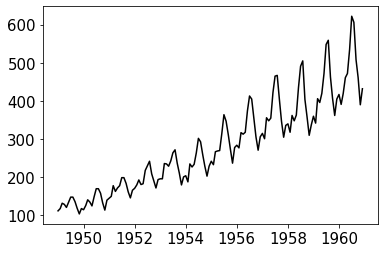

In [ ]:
# ----- Cambiamos el índice del dataframe por la fecha de la observación -----
dataframe.columns = ['Date', 'Passengers']
dataframe['Date'] = pd.to_datetime(dataframe['Date'], format='%Y-%m')
dataframe = dataframe.set_index('Date')
dataframe.head()

plt.plot(dataframe, color='black')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

Nos quedamos con la serie de valores del dataframe

In [ ]:
dataset = dataframe.values
dataset = dataset.astype('float32')
print(f"Serie de tiempo: {dataset[:3].reshape(-1,)} ... {dataset[-4:].reshape(-1,)}")

Serie de tiempo: [112. 118. 132.] ... [508. 461. 390. 432.]


## Preprocesamiento de los datos

Necesitamos generar los conjunto $X$, $Y$ para la red LSTM. El conjunto $X$ es el conjunto que ya tenemos de datos de la serie de tiempo. El conjunto $y$ es la misma serie de tiempo, *adelantada* $l_b=1$ observación. Es decir, si la serie de tiempo esta dada por $x_0,x_1,...,x_n$, tendremos:

$$X = (x_0,x_1,...,x_{n-2})$$
$$Y = (x_1,x_2,...,x_{n-1})$$

Podemos variar el parámetro $l_b$ (look back).

Definimos una función que genere los arreglos $X$, $Y$.

In [ ]:
def create_dataset(x, look_back=1):
	dataX, dataY = [], []
	for i in range(len(x)-look_back-1):
		a = x[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(x[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [ ]:
def create_dataset(data, look_back=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, look_back+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

Veamos como quedarían los datos

In [ ]:
print(f"Tamaño de la serie inicial: {dataset.shape[0]}")
print(f"Serie de tiempo original: {dataset[:3].reshape(-1,)} ... {dataset[-4:].reshape(-1,)}")

X, y = create_dataset(dataset,1)

print(f"\nTamaño de las series para la LSTM: {X.shape[0]}")
print(f"Serie de tiempo modificada X: {X[:3].reshape(-1,)} ... {X[-3:].reshape(-1,)}")
print(f"Serie de tiempo modificada Y: {y[:3].reshape(-1,)} ... {y[-3:].reshape(-1,)}")

Tamaño de la serie inicial: 144
Serie de tiempo original: [112. 118. 132.] ... [508. 461. 390. 432.]

Tamaño de las series para la LSTM: 142
Serie de tiempo modificada X: [112. 118. 132.] ... [606. 508. 461.]
Serie de tiempo modificada Y: [118. 132. 129.] ... [508. 461. 390.]


Re-escalamos los datos para que queden en el intervalo $[0,1]$.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
dataset[:5]

array([[0.01544401],
       [0.02702703],
       [0.05405405],
       [0.04826255],
       [0.03281853]], dtype=float32)

Dividimos en entrenamiento y prueba. Observar que los datos deben ser divididos en forma *ordenada*, es decir:

$$X_{train} = \{ x_0, ... , x_k\} $$
$$X_{test} = \{ x_{k+1}, ... , x_n\} $$

In [ ]:
train_ratio = 0.7

train_size = int(len(dataset) * train_ratio)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# ----- Generamos los conjuntos X,Y -----
look_back = 1
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

# ----- reshape input to be [samples, time steps, features] -----
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")

Shape of X_train: (98, 1, 1)
Shape of X_test: (42, 1, 1)


## Definimos y entrenamos el modelo

La célula de LSTM se encuentra implementada en [Keras](https://keras.io/api/layers/recurrent_layers/lstm/) como `LSTM`. Algunos de los parámetros importantes son:

* `units`: Positive integer, dimensionality of the output space. En este ejemplo, el valor es 4.
* `activation`: Activation function to use. Default: hyperbolic tangent (tanh). If you pass None, no activation is applied (ie. "linear" activation: a(x) = x).
* `recurrent_activation`: Activation function to use for the recurrent step. Default: sigmoid (sigmoid). If you pass None, no activation is applied (ie. "linear" activation: a(x) = x).

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# ------ Creamos el modelo ------
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))

# ------ Compilamos el modelo ------
model.compile(loss='mean_squared_error', optimizer='adam')

**¿Cómo podemos combinar capas LSTM?**

Es posible apilar capas LSTM en arquitecturas de redes profundas para entrenarse juntas, compartiendo la memoría entre ellas. 

Las capas LSTM pueden apilarse en Keras de la misma manera que otros tipos de capas. El requisito para hacerlo es que la primer capa devuelva la secuencia para que sea recibida por la segunda capa. Esto se puede hacer estableciendo el parámetro `return_sequence` como *True*.

In [ ]:
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.layers import LSTM

# # ------ Creamos el modelo ------
# model = Sequential()
# model.add(LSTM(4, input_shape=(1, look_back)),return_sequence=True)
# model.add(LSTM(4))
# model.add(Dense(1))

# # ------ Compilamos el modelo ------
# model.compile(loss='mean_squared_error', optimizer='adam')

Entrenamos el modelo

In [ ]:
model.fit(X_train, Y_train, epochs=100, batch_size=1, verbose=2)

## Obtenemos las predicciones y evaluamos el desempeño de la red

Realizamos las predicciones

In [ ]:
# make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

Aplicamos la transformación inversa del escalador, para obtener los valores en su escala original.

In [ ]:
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

Calculamos el error en las predicciones. Al ser un problema de regresión, usamos una pérdida y métrica de regresión: RMSE, MSE, MAE, etc.

In [ ]:
# calculate root mean squared error
train_score = math.sqrt(mean_squared_error(Y_train[0], train_predict[:,0]))
print('Train Score RMSE: %.2f' % (train_score))
test_score = math.sqrt(mean_squared_error(Y_test[0], test_predict[:,0]))
print('Test Score RMSE: %.2f' % (test_score))

Train Score RMSE: 23.40
Test Score RMSE: 49.71


Graficamos las predicciones, tanto en train como en test

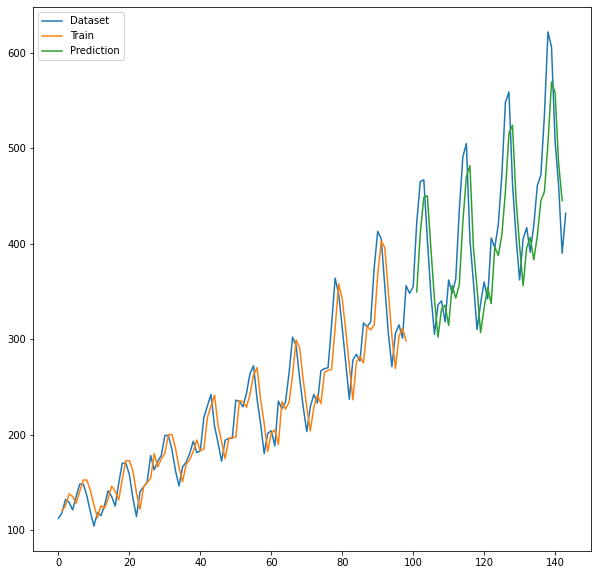

In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(dataset)-1, :] = test_predict

# plot baseline and predictions
plt.figure(figsize=(10,10))
plt.plot(scaler.inverse_transform(dataset),label='Dataset')
plt.plot(trainPredictPlot,label='Train')
plt.plot(testPredictPlot,label='Prediction')
plt.legend(loc='best')
plt.show()

## Una arquitectura más compleja

Probemos con una arquitectura más profunda. Observar que las capas LSTM regresan las secuencias, de esta forma, se entrenan juntas y comparten la memoria.

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM

lstmModel = Sequential()
lstmModel.add(LSTM(100, activation="ReLU", return_sequences=True, input_shape=(trainX.shape[1], 1)))
lstmModel.add(Dropout(0.2))
lstmModel.add(LSTM(80, activation="ReLU", return_sequences=True))
lstmModel.add(Dropout(0.2))
lstmModel.add(LSTM(50, activation="ReLU", return_sequences=True))
lstmModel.add(Dropout(0.2))
lstmModel.add(LSTM(30, activation="ReLU"))
lstmModel.add(Dense(1))

lstmModel.summary()

model.compile(loss='mean_squared_error', optimizer='adam')

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 1, 100)            40800     
                                                                 
 dropout_3 (Dropout)         (None, 1, 100)            0         
                                                                 
 lstm_7 (LSTM)               (None, 1, 80)             57920     
                                                                 
 dropout_4 (Dropout)         (None, 1, 80)             0         
                                                                 
 lstm_8 (LSTM)               (None, 1, 50)             26200     
                                                                 
 dropout_5 (Dropout)         (None, 1, 50)             0         
                                                                 
 lstm_9 (LSTM)               (None, 30)               

Entrenamos el modelo

In [ ]:
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Hacemos las predicciones

In [ ]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

Invertimos las predicciones (des-escalamos)

In [ ]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

Obtenemos las métricas de evaluación

In [ ]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 22.81 RMSE
Test Score: 48.52 RMSE


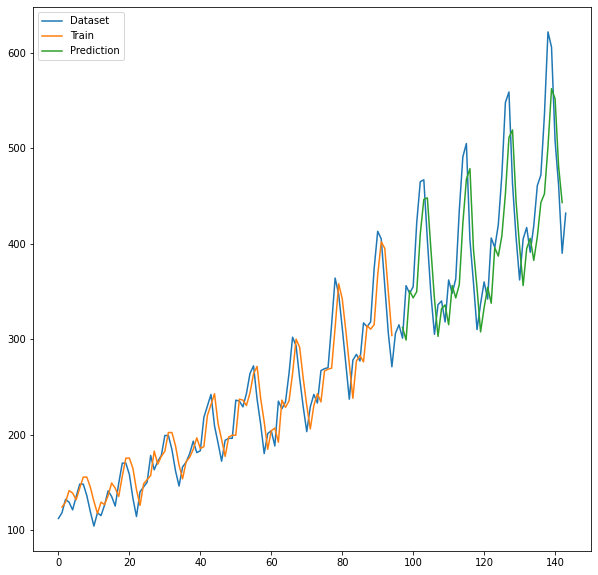

In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.figure(figsize=(10,10))
plt.plot(scaler.inverse_transform(dataset),label='Dataset')
plt.plot(trainPredictPlot,label='Train')
plt.plot(testPredictPlot,label='Prediction')
plt.legend(loc='best')
plt.show()

# Window Method

Otra manera de plantear el probemas es considerar que varios datos previos pueden ser usado para predecir el siguiente dato de una serie de tiempo.

A estos multiples valores pasdos se les llama *ventana*, el tamaño de la ventana puede variarse y depende del problema.

For example, given the current time (t) we want to predict the value at the next time in the sequence (t+1), we can use the current time (t), as well as the two prior times (t-1 and t-2) as input variables.

When phrased as a regression problem, the input variables are t-2, t-1, t and the output variable is t+1.

Es decir, si la serie de tiempo esta dada por $x_0,x_1,...,x_n$, tendremos:

\begin{align}
X = 
\begin{pmatrix}
    x_0 & x_1 & x_2 \\
    x_1 & x_2 & x_3 \\
     & ... & \\
    x_{n-3} & x_{n-2} & x_{n-1}
    \end{pmatrix}
\end{align}

\begin{align}
Y = 
\begin{pmatrix}
    x_3 \\
    x_4 \\
    ...\\
    x_n
    \end{pmatrix}
\end{align}
    


⭕ Ejercicio: 
* Encuentra un valor para el $l_p$ que mejore el desempeño de la LSTM anterior.
* Puedes usar también capas de dropout y callbacks.


---


Hay varios técnicas más para LSTM, por ejemplo:

* **Diferenciación de datos.** Los datos estacionarios son más fáciles de modelar. Este tipo de datos no tiene una estructura que dependa del tiempo. En el caso de los conjuntos de datos no estacionarios, por ejemplo, si los datos tienen una tendencia creciente, la tendencia puede eliminarse de las observaciones y volver a añadirse a las previsiones más adelante para devolver la predicción a la escala original. Una forma estándar de eliminar una tendencia es diferenciar los datos.

In [ ]:
t